In [209]:
%pip install pyecharts

Note: you may need to restart the kernel to use updated packages.


In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


# 加载数据,查看数据

In [211]:
df_trade = pd.read_csv('tianchi_mum_baby_trade_history.csv')
df_baby = pd.read_csv('tianchi_mum_baby.csv')

| 字段         | 字段说明     | 
| ----------- | ------------ | 
| user_id     | 用户标识     | 
| auction_id  | 交易ID       | 
| cat1  | 商品一级类目 | 
| cat2  | 商品一级类目 | 
| buy_mount   | 购买数量     |              |
| day         | 交易时间     |


In [212]:
df_trade.head()

,user_id,auction_id,cat1,cat2,buy_mount,day
0,786295544,41098319944,50022520,50014866,2,20140919
1,532110457,17916191097,28,50011993,1,20131011
2,249013725,21896936223,50014815,50012461,1,20131011
3,917056007,12515996043,50014815,50018831,2,20141023
4,444069173,20487688075,50008168,50013636,1,20141103


| 字段     | 字段说明   | 提取说明        |
| ------- | ---------- | --------------- |
| user_id | 用户标识   | 抽样 |
| birthday| 出身日期   | YYYYMMDD，精确到天 |
| gender  | 性别       | 0：男孩，1：女孩，2：性别不明 |

In [213]:
df_baby.head()

,user_id,birthday,gender
0,2757,20130311,1
1,415971,20121111,0
2,1372572,20120130,1
3,10339332,20110910,0
4,10642245,20130213,0


#  数据预处理
## 在进入正式分析之前，我们先来宏观的观察数据

In [214]:
df_trade.dtypes

user_id       int64
auction_id    int64
cat1          int64
cat2          int64
buy_mount     int64
day           int64
dtype: object

## 可以看到，pandas识别到6个int类型字段，我们将day转化为datetime类型（年-月-日）：

In [215]:
df_trade['day'] = pd.to_datetime(df_trade.day.astype('str'))
df_trade.head()

,user_id,auction_id,cat1,cat2,buy_mount,day
0,786295544,41098319944,50022520,50014866,2,2014-09-19
1,532110457,17916191097,28,50011993,1,2013-10-11
2,249013725,21896936223,50014815,50012461,1,2013-10-11
3,917056007,12515996043,50014815,50018831,2,2014-10-23
4,444069173,20487688075,50008168,50013636,1,2014-11-03


## 因为后续我们会基于年、季、月来分析数据变化趋势，为方便起见，我们为df_trade表增加对应的字段：

In [216]:
df_trade['year'] = df_trade.day.dt.year
df_trade['quarter'] = df_trade.day.dt.quarter
df_trade['month'] = df_trade.day.dt.month
df_trade.head()

,user_id,auction_id,cat1,cat2,buy_mount,day,year,quarter,month
0,786295544,41098319944,50022520,50014866,2,2014-09-19,2014,3,9
1,532110457,17916191097,28,50011993,1,2013-10-11,2013,4,10
2,249013725,21896936223,50014815,50012461,1,2013-10-11,2013,4,10
3,917056007,12515996043,50014815,50018831,2,2014-10-23,2014,4,10
4,444069173,20487688075,50008168,50013636,1,2014-11-03,2014,4,11


## 我们来看下df_trade表的时间跨度，从12年7月份到15年2月份，其中完整的年份是13、14年：

In [217]:
df_trade.day.describe()

count                            29971
mean     2014-01-16 17:25:38.086817536
min                2012-07-02 00:00:00
25%                2013-06-20 00:00:00
50%                2014-03-06 00:00:00
75%                2014-09-09 00:00:00
max                2015-02-05 00:00:00
Name: day, dtype: object

## 我们再来宏观看下交易量：

In [218]:
df_trade.buy_mount.describe()

count    29971.000000
mean         2.544126
std         63.986879
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max      10000.000000
Name: buy_mount, dtype: float64

## 可以看到，大部分的购买数量都是1（75%水位），但是最大值有10000次，考虑到母婴行业的特性，正常消费场景下，一般很少有一次性购买10000件的商品。一般我们取标准差(std)3倍以内的数据作为正常区间，63 * 3 = 189，我们保留buy_mount 189以内的数据：

In [219]:
df_trade = df_trade[(df_trade.buy_mount >= 1) & (df_trade.buy_mount <= 189)]
df_trade.buy_mount.describe()

count    29940.000000
mean         1.656179
std          5.026888
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        176.000000
Name: buy_mount, dtype: float64

## 可以看到，df_trade表原始数据有29971条，过滤后的数据有29940条

In [220]:
count_user = df_trade.user_id.nunique()
count_auction = df_trade.auction_id.nunique()
count_category_1 = df_trade.cat1.nunique()
count_category_2 = df_trade.cat2.nunique()
count_buy_mount = df_trade.buy_mount.sum()
print("用户数", count_user)
print("交易数", count_auction)
print("商品一级类目数：", count_category_1)
print("商品二级类目数：", count_category_2)
print("总销量：", count_buy_mount)

用户数 29913
交易数 28392
商品一级类目数： 6
商品二级类目数： 662
总销量： 49586


# 对df_baby表进行数据清洗
## 为方便分析，过滤掉性别“未知”的数据条目：

In [221]:
df_baby.count()

user_id     953
birthday    953
gender      953
dtype: int64

In [222]:
df_baby = df_baby[df_baby.gender != 2]
df_baby

,user_id,birthday,gender
0,2757,20130311,1
1,415971,20121111,0
2,1372572,20120130,1
3,10339332,20110910,0
4,10642245,20130213,0
...,...,...,...
948,2020957900,20140430,0
949,2080304899,20100713,0
950,2114469016,20140416,0
951,2186831536,20140519,1


有效数据量从953条变成927条
## 同样的，我们将birthday字段转为datetime类型：

In [223]:
df_baby['birthday'] = pd.to_datetime(df_baby.birthday.astype('str'))
df_baby.birthday.describe()

count                              927
mean     2012-03-04 16:37:16.893203712
min                1984-06-16 00:00:00
25%                2011-02-09 12:00:00
50%                2012-08-07 00:00:00
75%                2013-09-26 12:00:00
max                2015-08-15 00:00:00
Name: birthday, dtype: object

## 我们发现居然有1984年出生的婴儿数据，因为淘宝网是2003年才诞生的，网购的消费习惯多形成在2010年前后，因此我们剔除掉异常的生日数据


In [224]:
df_baby = df_baby[df_baby.birthday > '2010-01-01']
df_baby.birthday.describe()

count                              798
mean     2012-11-01 04:10:49.624060160
min                2010-01-05 00:00:00
25%                2011-10-17 18:00:00
50%                2012-11-25 00:00:00
75%                2013-11-23 06:00:00
max                2015-08-15 00:00:00
Name: birthday, dtype: object

## 可以看到，经过数据过滤后，df_baby表的数据从原始的953条缩小到798条。

In [225]:
df_baby.head()

,user_id,birthday,gender
0,2757,2013-03-11,1
1,415971,2012-11-11,0
2,1372572,2012-01-30,1
3,10339332,2011-09-10,0
4,10642245,2013-02-13,0


# 数据分析
## 数据分析阶段，我们会从年/季度/月、商品类目（一级类目）、用户性别维度等多个维度对df_trade表和df_baby表进行数据分析和可视化：

## 流量分析
我们从年、季度、月、天的角度来对购买量进行分析：

根据年月查看销量趋势

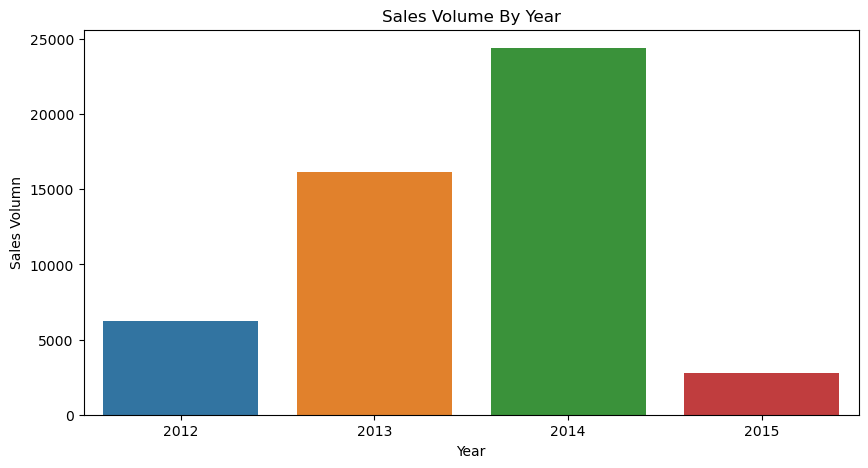

In [226]:
year_stats = df_trade.groupby(by='year')['buy_mount'].sum()

plt.figure(figsize=(10, 5))
sns.barplot(x=year_stats.index, y=year_stats.values)

plt.title("Sales Volume By Year")
plt.xlabel("Year")
plt.ylabel("Sales Volumn")
plt.show()

在数据预处理章节我们得知，本次抽样数据跨度为2012/07到2015/02，2013、2014为两个完整的年份，趋势应该是逐年递增的，符合淘宝的发展趋势。

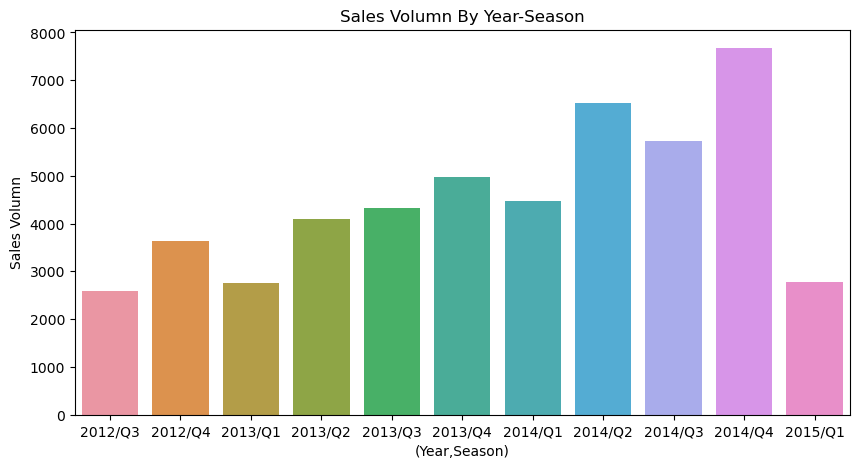

In [227]:
# 各年季度销量情况
year_quarter_stats = df_trade.groupby(by=['year', 'quarter'])['buy_mount'].sum()

plt.figure(figsize=(10, 5))
x_list = [str(idx[0]) + "/Q" + str(idx[1]) for idx in year_quarter_stats.index]
y_list = [int(value) for value in year_quarter_stats.values]
sns.barplot(x=x_list, y=y_list)
plt.title("Sales Volumn By Year-Season")
plt.xlabel("(Year,Season)")
plt.ylabel("Sales Volumn")
plt.show()


以2013、2014两个完整年为例，一般规律是Q1为全年销量最低的年份、Q4是全年销量最高的年份

猜想一个可能的原因是Q1因为春节假期导致的销量下滑，Q4是因为有双十一、双十二营销活动带来的增长。

我们可以再按月分析来验证我们的结论：
## 根据年月分组

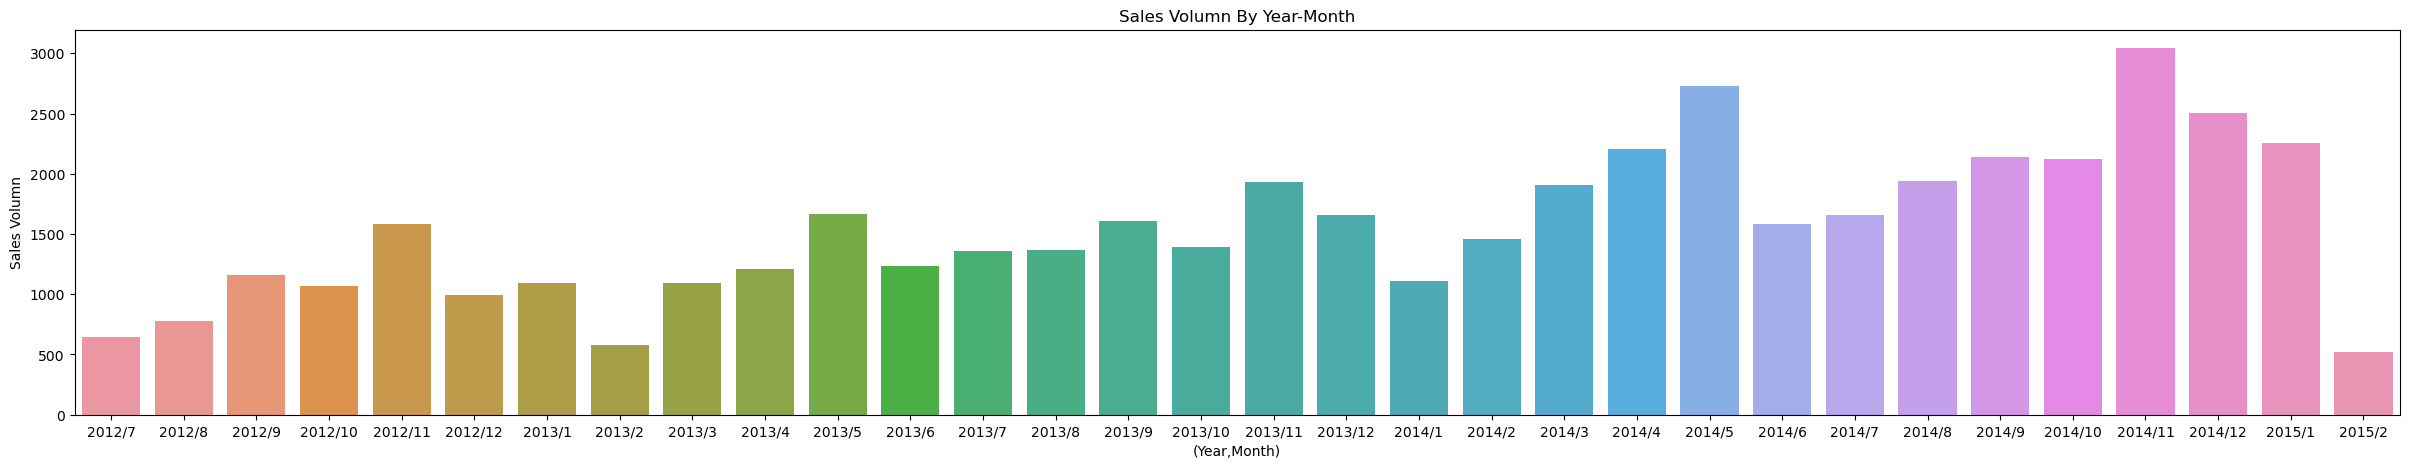

In [228]:
year_month_stats = df_trade.groupby(by=['year', 'month'])['buy_mount'].sum()

plt.figure(figsize=(30, 5))
x_list = [str(idx[0]) + "/" + str(idx[1]) for idx in year_month_stats.index]
y_list = [int(value) for value in year_month_stats.values]
sns.barplot(x=x_list, y=y_list)

plt.title("Sales Volumn By Year-Month")
plt.xlabel("(Year,Month)")
plt.ylabel("Sales Volumn")
plt.show()


还是以2013、2014年为例，2013年2月份、2014年1月份为全年销量最低，通过万年历查询我们知道这两个月份刚好位当年的春节所在的月份，11月份分别为两年的销售高峰。

初步印证了我们关于春节和双十一营销活动对销量带来影响的猜想。 

我们可以更进一步，以天为单位来观察销量数据，我们仅以2014年11月的数据为例

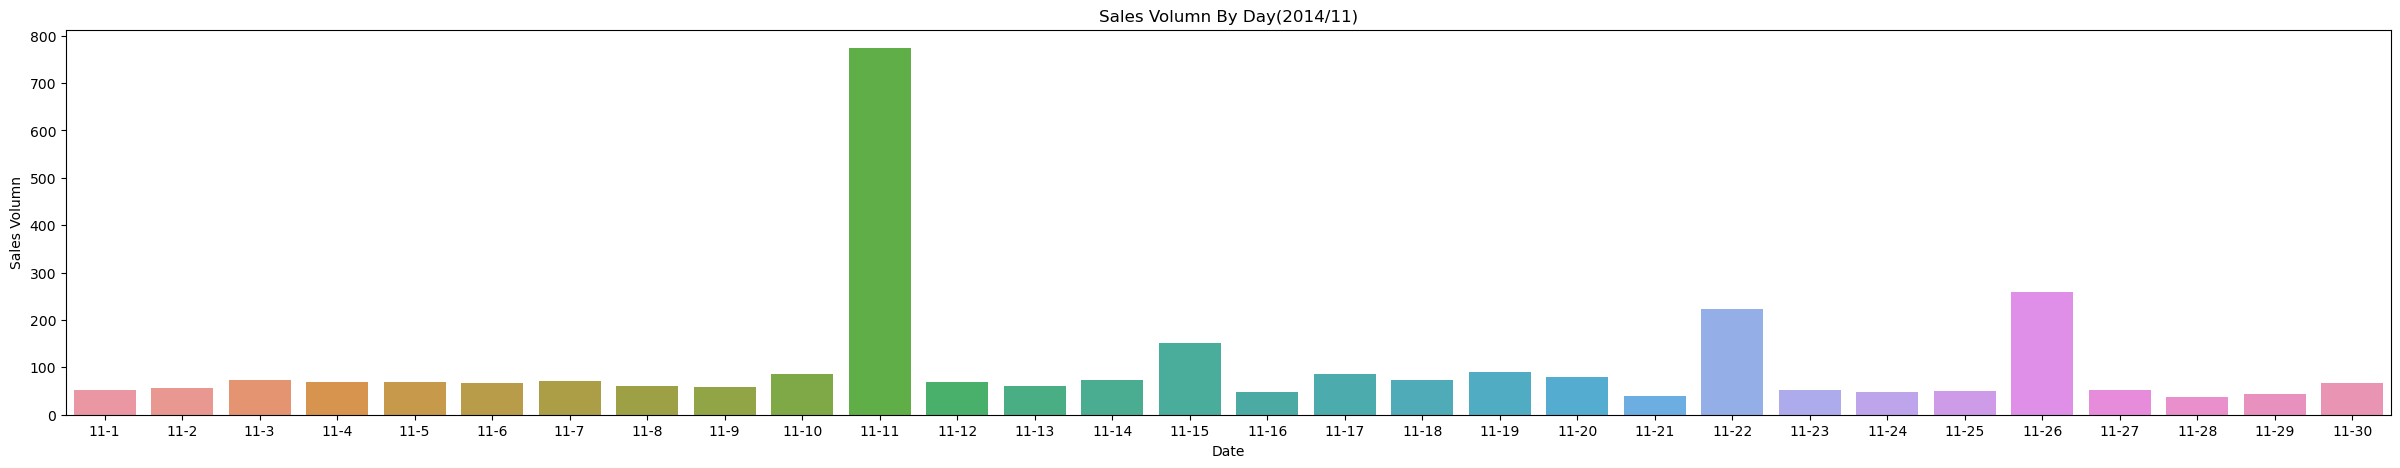

In [229]:
df_trade_201411 = df_trade[(df_trade.day >= '2014-11-01') & (df_trade.day <= '2014-11-30')]
day_stats = df_trade_201411.groupby(by='day')['buy_mount'].sum()

plt.figure(figsize=(30, 5))
x_list = [str(idx.month) + '-' + str(idx.day) for idx in day_stats.index]
y_list = [int(value) for value in day_stats.values]
sns.barplot(x=x_list, y=y_list)

plt.title("Sales Volumn By Day(2014/11)")
plt.xlabel("Date")
plt.ylabel("Sales Volumn")
plt.show()


可以看到，相比其他日期，双11购物节当天的销量出现了顶峰。 


## 类目分析
在数据预处理章节，我们知道本次抽样数据共包含6个商品大类（一级类目）和662个商品小类（二级类目）。

因本次抽样数据样本量较小，因此我们主要分析商品一级类目。 我们先来看看商品一级类目的销量情况：

## 商品大类销售情况

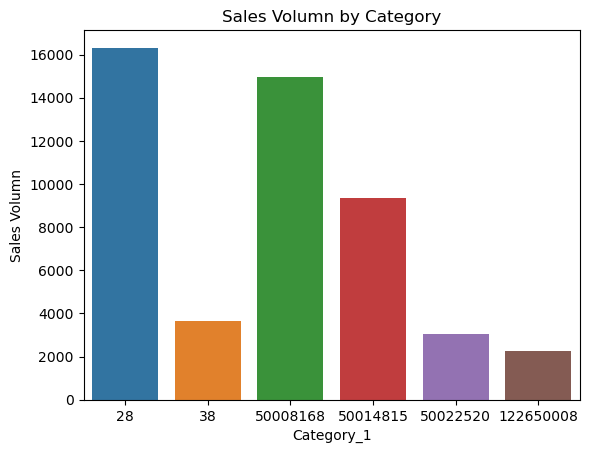

In [230]:
category_1_stats = df_trade.groupby(by="cat1")['buy_mount'].sum()
sns.barplot(x=category_1_stats.index, y=category_1_stats.values)
plt.title("Sales Volumn by Category")
plt.xlabel("Category_1")
plt.ylabel('Sales Volumn')
plt.show()

## 年龄分析

根据交易时间和孩子出生日期来判断孩子的年龄：

In [231]:
df_merge = pd.merge(df_trade, df_baby)

In [232]:
df_merge['age'] = round(( df_merge['day'] - df_merge['birthday'] ) / pd.Timedelta(days = 365) , 2)
df_merge

,user_id,auction_id,cat1,cat2,buy_mount,day,year,quarter,month,birthday,gender,age
0,513441334,19909384116,50008168,50010557,1,2012-12-12,2012,4,12,2011-01-05,1,1.94
1,377550424,15771663914,28,50015841,1,2012-11-23,2012,4,11,2011-06-20,1,1.43
2,47342027,14066344263,50008168,50013636,1,2012-09-11,2012,3,9,2010-10-08,1,1.93
3,119784861,20796936076,50008168,50140021,1,2012-11-29,2012,4,11,2012-03-27,0,0.68
4,159129426,15198386301,50008168,50013711,2,2012-08-08,2012,3,8,2010-08-25,0,1.96
...,...,...,...,...,...,...,...,...,...,...,...,...
796,379910739,12881672070,50008168,50012451,2,2012-09-04,2012,3,9,2011-02-26,0,1.52
797,685332320,12781785338,50014815,50018831,2,2013-06-01,2013,2,6,2012-02-23,0,1.27
798,389326420,17164967407,28,50006820,1,2014-09-16,2014,3,9,2013-07-17,0,1.17
799,1372572,16915013171,28,50008845,1,2013-03-27,2013,1,3,2012-01-30,1,1.16


In [233]:
df_merge.age.describe()

count    801.000000
mean       1.205106
std        1.267036
min       -2.090000
25%        0.250000
50%        0.980000
75%        2.080000
max        4.840000
Name: age, dtype: float64

我们发现年龄的最小值有负数，因此我们过滤掉年龄小于0的数据, 最终得到663条数据, 最大年龄4岁，最小年龄为刚出生的婴儿，平均年龄为1.5岁。

In [234]:
df_merge = df_merge[df_merge.age > 0]
df_merge.age.describe()

count    663.000000
mean       1.537979
std        1.122517
min        0.020000
25%        0.590000
50%        1.250000
75%        2.300000
max        4.840000
Name: age, dtype: float64

In [235]:
df_merge.to_csv('df_merge.csv', index=False)

## 性别分析

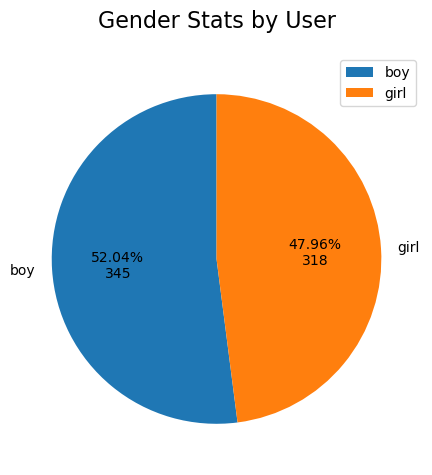

In [236]:
# 计算比例函数
def compute_fraction(pct, allvals):
    absolute = int(pct/100 * np.sum(allvals))
    return '{:.2f}%\n{:d}'.format(pct, absolute)

gender_stats_by_user = df_merge.groupby(by = "gender")["user_id"].count()
#gender_stats_by_auction = df_merge.groupby(by = "gender")["auction_id"].count()

labels=['boy','girl']
values=np.array([gender_stats_by_user[0], gender_stats_by_user[1]])

fig=plt.figure()
sub=fig.add_subplot(111)
sub.pie(values, labels=labels, startangle=90, autopct=lambda x: compute_fraction(x,values))
sub.legend()
fig.suptitle('Gender Stats by User',fontsize=16)
fig.tight_layout()
plt.show()


## 商品大类和性别关联分析

In [237]:
gender_stats_by_buy_mount = df_merge.groupby(by = ['gender','cat1'])['buy_mount'].sum()
gender_stats_by_buy_mount.to_csv("gender_stats_by_buy_mount.csv",index=True)
gender_stats_by_buy_mount

gender  cat1     
0       28           112
        38            94
        50008168     154
        50014815     303
        50022520      14
        122650008     23
1       28            81
        38            37
        50008168     158
        50014815      87
        50022520      14
        122650008     19
Name: buy_mount, dtype: int64

## 男孩的类别销量统计：

Text(0.5, 0.98, 'Sales Volumn by Boy')

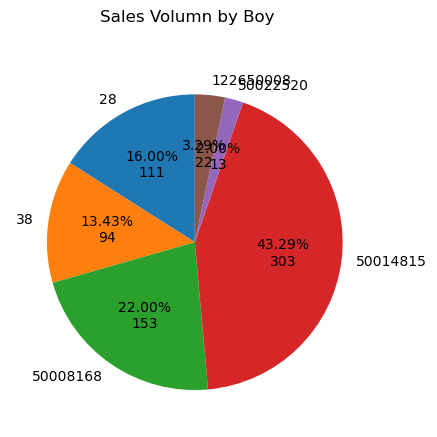

In [238]:
category_1_list = [28, 38, 50008168, 50014815, 50022520, 122650008]
values = np.array([gender_stats_by_buy_mount.loc[0, category] for category in category_1_list])

fig=plt.figure()
sub=fig.add_subplot(111)
sub.pie(values, labels=category_1_list, startangle=90, autopct=lambda x: compute_fraction(x,values))
fig.suptitle('Sales Volumn by Boy')

## 女孩的类别销量统计：

Text(0.5, 0.98, 'Sales Volumn by Girl')

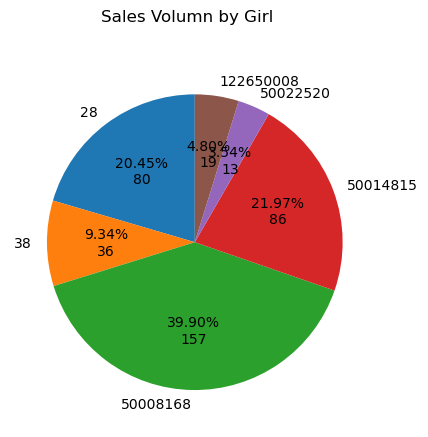

In [239]:

values = np.array([gender_stats_by_buy_mount.loc[1, category] for category in category_1_list])

fig=plt.figure()
sub=fig.add_subplot(111)
sub.pie(values, labels=category_1_list, startangle=90, autopct=lambda x: compute_fraction(x,values))
fig.suptitle('Sales Volumn by Girl')

## 分析结论：
可以看出，男、女两类婴幼儿用户的购买类别比例还是有较为明显的区别，和我们的常识有所出入。

## 课后作业
进一步基于年龄段（如 0.5岁以内、1岁以内、1-2岁、2-3岁、3-4岁）来继续分析，看看能得到什么进一步的结论。

In [240]:
age_categories = {
    '0-0.5': (0, 0.5),
    '0.5-1': (0.5, 1),
    '1-2': (1, 2),
    '2-3': (2, 3),
    '3-4': (3, 4),
    '4-5': (4,5)
}

# 根据年龄分配年龄类别的功能函数
def assign_age_category(age):
    for category, (lower_bound, upper_bound) in age_categories.items():
        if lower_bound <= age < upper_bound:
            return category
    return 'Other'

df_merge['age_category'] = df_merge['age'].apply(assign_age_category)

# 过滤掉“其他”类别，专注于指定的年龄范围。
df_merge_filtered = df_merge[df_merge['age_category'] != 'Other']

df_merge_filtered.head()


/var/folders/lj/lmb91jvd0zb9d59rd05y9xhw0000gn/T/ipykernel_27455/3982123259.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge['age_category'] = df_merge['age'].apply(assign_age_category)


,user_id,auction_id,cat1,cat2,buy_mount,day,year,quarter,month,birthday,gender,age,age_category
0,513441334,19909384116,50008168,50010557,1,2012-12-12,2012,4,12,2011-01-05,1,1.94,1-2
1,377550424,15771663914,28,50015841,1,2012-11-23,2012,4,11,2011-06-20,1,1.43,1-2
2,47342027,14066344263,50008168,50013636,1,2012-09-11,2012,3,9,2010-10-08,1,1.93,1-2
3,119784861,20796936076,50008168,50140021,1,2012-11-29,2012,4,11,2012-03-27,0,0.68,0.5-1
4,159129426,15198386301,50008168,50013711,2,2012-08-08,2012,3,8,2010-08-25,0,1.96,1-2


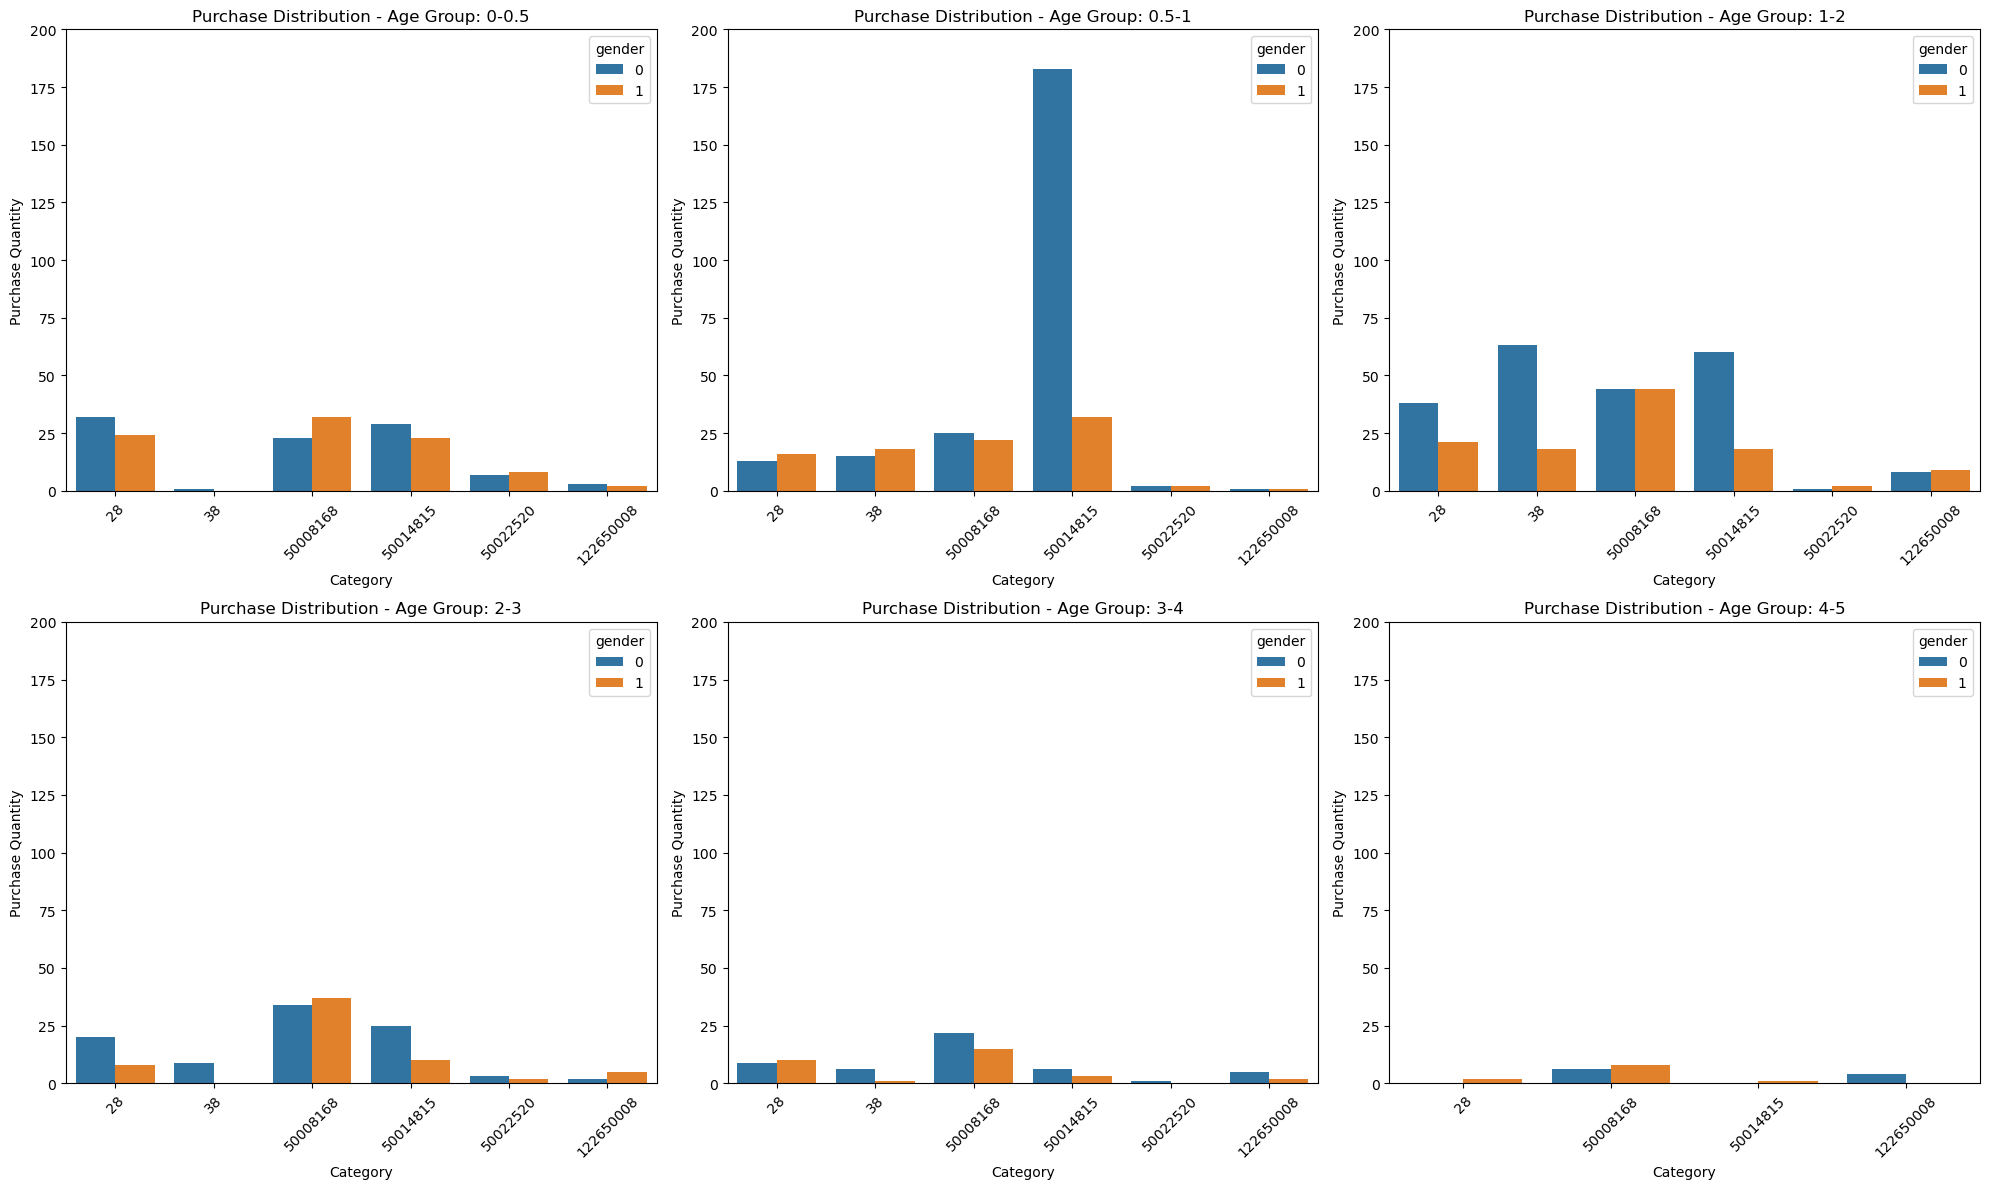

In [252]:
#按年龄类别、性别和分类1（cat1）对数据进行分组，并求购买的总和。
grouped_data = df_merge_filtered.groupby(['age_category', 'gender', 'cat1'])['buy_mount'].sum().reset_index()

# 绘制条形图，统一设置 y 轴范围为 0-200
plt.figure(figsize=(20, 12))

for i, age_category in enumerate(age_categories.keys()):
    plt.subplot(2, 3, i+1)
    data_subset = grouped_data[grouped_data['age_category'] == age_category]
    
    # 为每个性别绘制图形
    sns.barplot(x='cat1', y='buy_mount', hue='gender', data=data_subset)
    plt.title(f'Purchase Distribution - Age Group: {age_category}')
    plt.xlabel('Category')
    plt.ylabel('Purchase Quantity')
    plt.xticks(rotation=45)
    plt.ylim(0, 200)  # 设置 y 轴范围

plt.tight_layout()
plt.show()

In [247]:
from pyecharts import options as opts
from pyecharts.charts import Bar, Grid

# 创建条形图的函数
def create_bar_chart(data, age_group):

    categories = [str(cat) for cat in data['cat1'].unique()]
    
    bar = (
        Bar()
        .add_xaxis(categories)
        .add_yaxis("Male", list(data[data['gender'] == 1]['buy_mount']))
        .add_yaxis("Female", list(data[data['gender'] == 0]['buy_mount']))
        .set_global_opts(
            title_opts=opts.TitleOpts(title="Purchase Distribution", subtitle=""),
            xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=-45)),
            yaxis_opts=opts.AxisOpts(name=f"Purchase Quantity - Age Group: {age_group}"),
            tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="cross")
        )
        .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
    )
    return bar

# 创建网格图
grid = Grid(init_opts=opts.InitOpts(width="1200px", height="3000px"))

# 遍历每个年龄组并将条形图添加到网格中
for i, age_category in enumerate(age_categories.keys()):
    data_subset = grouped_data[grouped_data['age_category'] == age_category]
    bar_chart = create_bar_chart(data_subset, age_category)
    # 调整第一个图表的顶部位置，确保它完全显示
    pos_top = "100px" if i == 0 else f"{100 + i * 460}px"  # 对于第一个图表，顶部位置设置为 50px，之后的每个图表增加 400px
    grid.add(bar_chart, grid_opts=opts.GridOpts(pos_left="10%", pos_right="10%", pos_top=pos_top, height="350px"))

grid.render("purchase_distribution.html")

'/Users/jessezhang/Desktop/BJUT-AI-Major-Courses/Data-Mining/purchase_distribution.html'

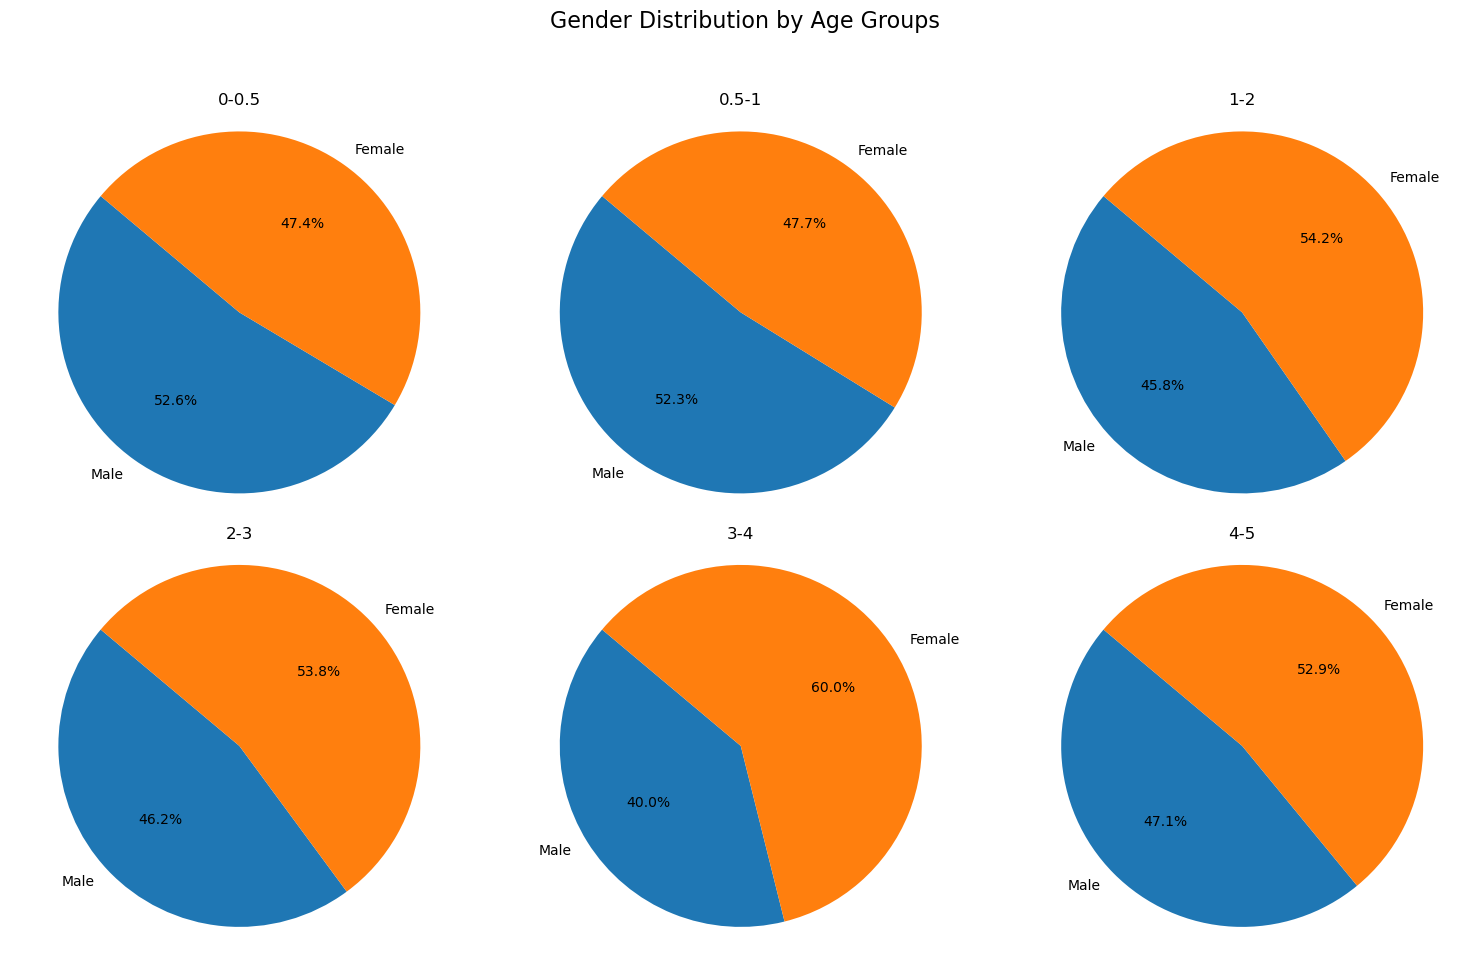

In [249]:
age_gender_counts = {age_group: {'Male': 0, 'Female': 0} for age_group in age_categories}

for _, row in df_merge.iterrows():
    age = row['age']
    gender = 'Male' if row['gender'] == 1 else 'Female'
    
    for age_group, (min_age, max_age) in age_categories.items():
        if min_age <= age < max_age:
            age_gender_counts[age_group][gender] += 1
            break

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Gender Distribution by Age Groups', fontsize=16)

for ax, (age_group, counts) in zip(axes.flatten(), age_gender_counts.items()):
    labels = counts.keys()
    sizes = counts.values()

    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.set_title(age_group)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

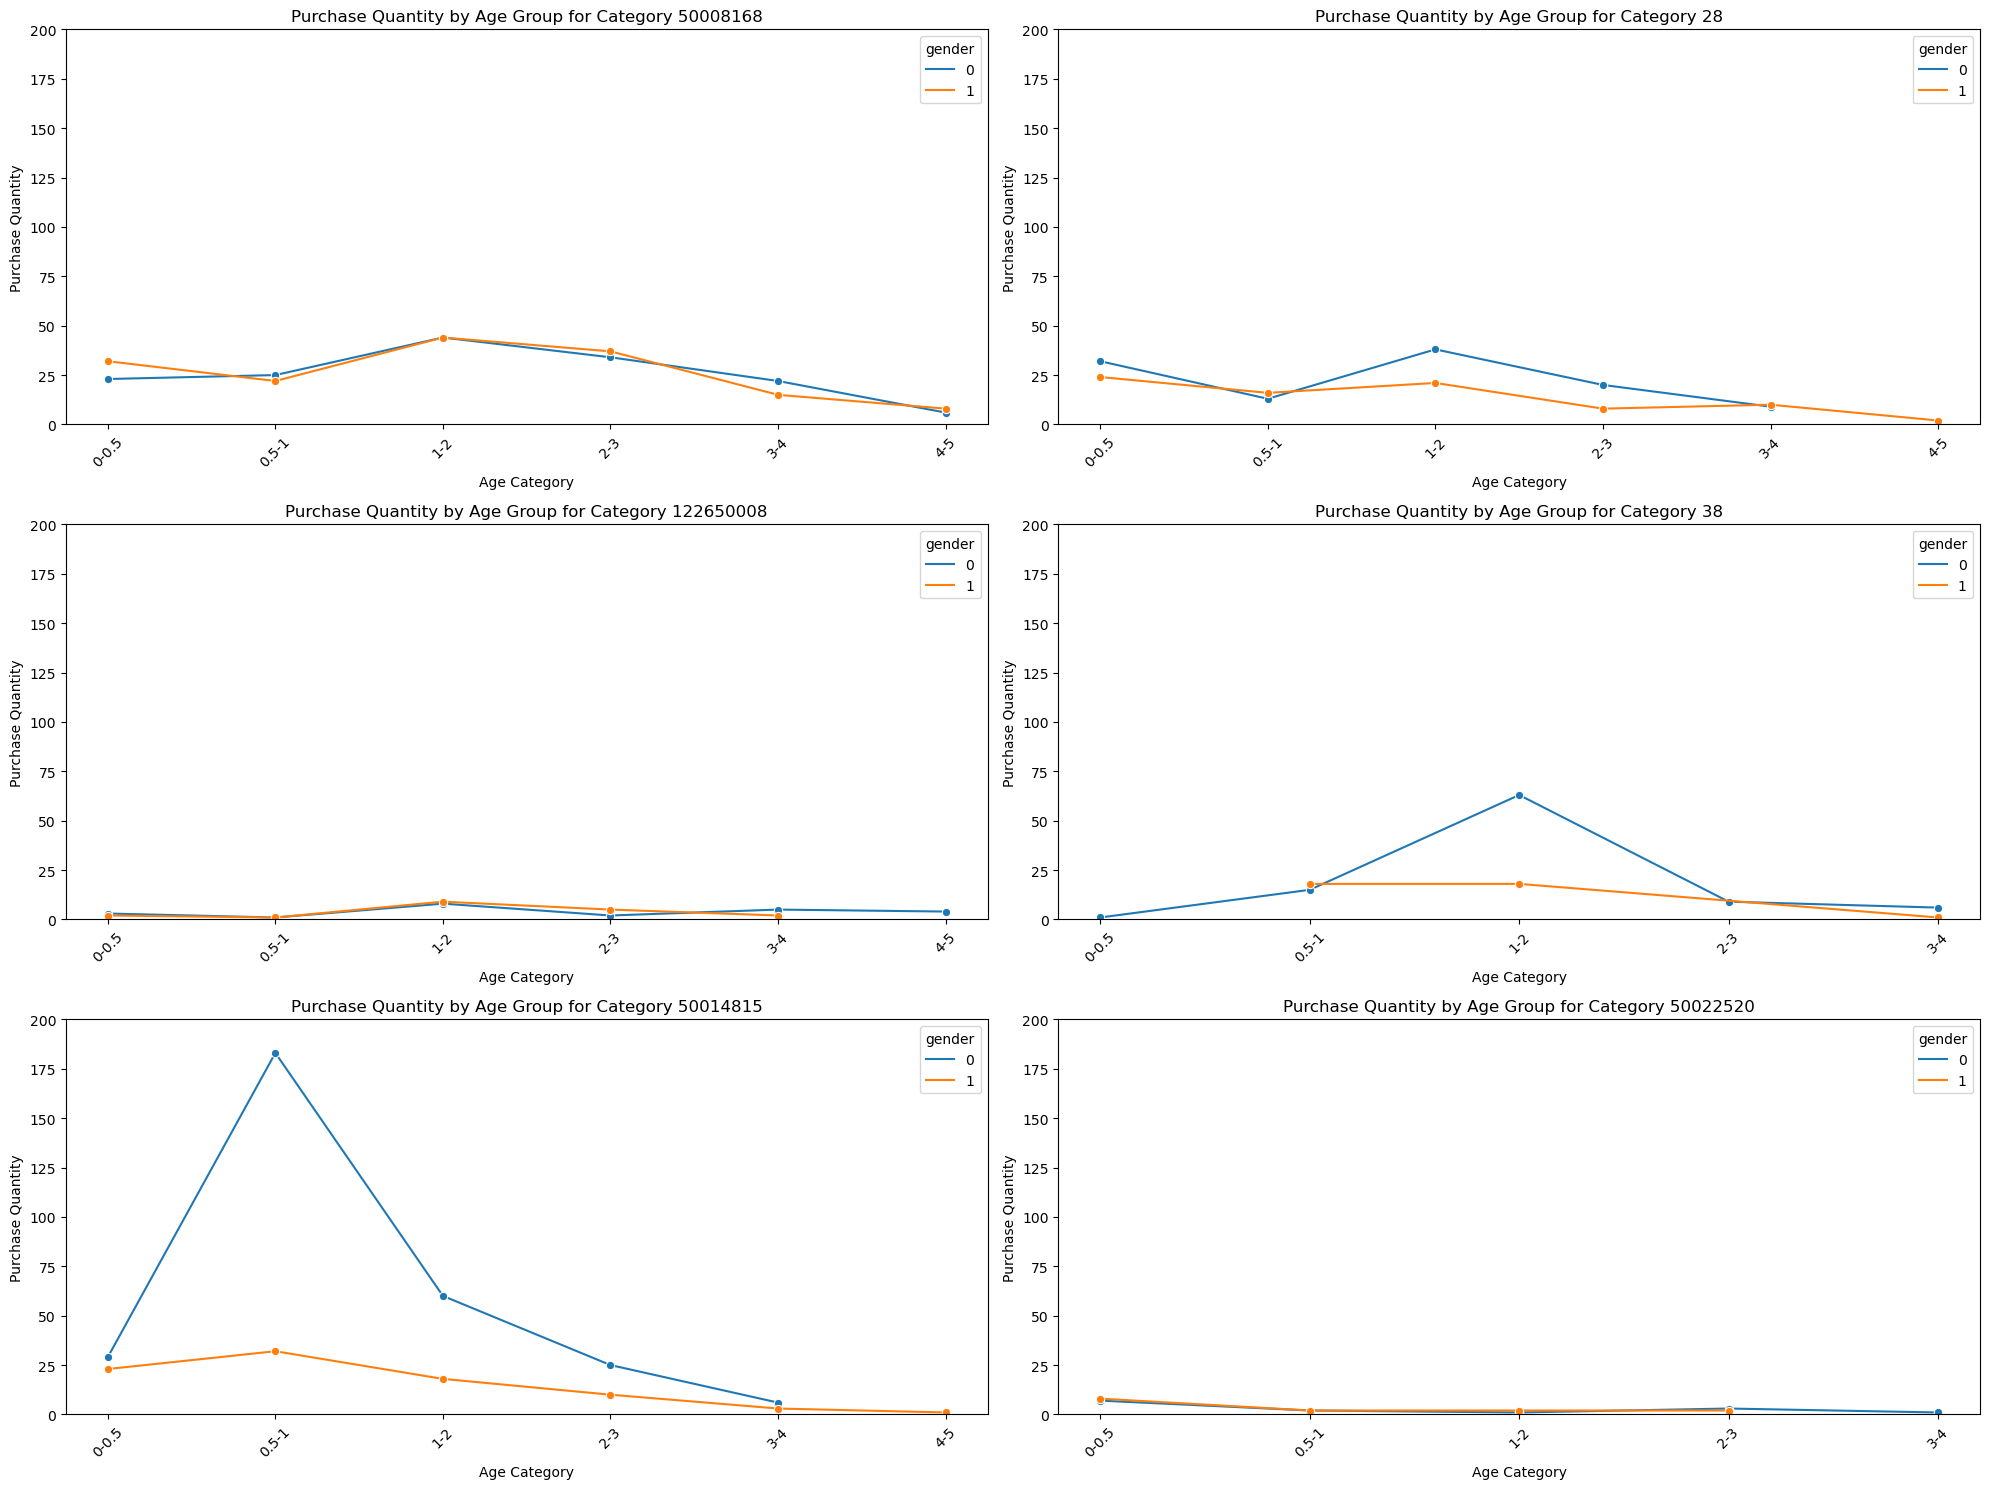

In [253]:
product_categories = df_merge['cat1'].unique()

# 绘制所有商品类别的折线图，统一设置 y 轴范围为 0-200
plt.figure(figsize=(20, 15))

for i, category in enumerate(product_categories):
    plt.subplot(3, 2, i+1)
    category_data = grouped_data[grouped_data['cat1'] == category]
    sns.lineplot(x='age_category', y='buy_mount', hue='gender', data=category_data, marker='o')
    plt.title(f'Purchase Quantity by Age Group for Category {category}')
    plt.xlabel('Age Category')
    plt.ylabel('Purchase Quantity')
    plt.xticks(rotation=45)
    plt.ylim(0, 200)  # 设置 y 轴范围

plt.tight_layout()
plt.show()


- “122650008”和“50022520”产品购买需求始终较低。
- 所有产品都随着年龄增长需求减少。
- 女婴在 0.5-1 年龄区间，对于“50014815”需求购买需求较大。
- “50014815”产品男婴购买需求始终较低。
- 性别差异在购买行为上存在，但其具体表现因类别和年龄段而异。总体来讲女婴购买量大于男婴。